## Final Project Submission

Please fill out:
* Student name: Joel Omondi, Aaron Onserio, James Mbeti, Victoria Nabea, Nyokabi Waiganjo, Kennedy Juma
* Student pace: full time
* Scheduled project review date/time: 20/04/2023
* Instructor name: Lucille Kaleha
* Blog post URL: 


# **VALUE ANALYSIS FOR HOUSE SALE PRICES IN KING COUNTY**

## **Business Overview**
## _Will your home renovations pay off?_

>> ### **Introduction**

* In this project, the task is to undertake research on property market in King County and to determine the major factors for the houses within the neighbourhoods for a real estate agency.

* The objective of this project is to utilize multiple linear regression modeling to evaluate house sales data in King County Washington, USA. The aim is to gain insights and make predictions about the factors that affect house sales in the area as well as lucrative neighbourhoods to invest in while using statistical techniques to support relevant recommendations.

* Remodeling certain areas of a property is an excellent way for homeowners to add increased functionality and beauty to a property at someone else's expense. By choosing the right project to enhance your living space, a significant portion of the expense can be passed on to future owners in the form of increased property values


>> ### **Business Problem / Problem Statement**

The real estate agency needs to provide advice to homeowners regarding how home renovations can potentially increase the estimated value of their properties and homes and by what amount. This information will assist the real estate agency in advising their clients about how to make informed decisions regarding home renovations, and in turn, assist homeowners in maximizing the return on their investment when selling their properties.


>> ### **Proposal**

* We will focus on analysing house sales in a northwestern county for a possible stakeholder, a real estate agency helping homeowners buy and/or sell homes. Specifically, we will address the business problem of providing homeowners advice on how home renovations can increase the estimated value of their homes and by what amount.

* 



## **Data Understanding**

* This project uses the King County House Sales dataset, which can be found in "kc_house_data.csv"

* One of the challenges that may arise in this project is the incomplete or ambiguous description of the column names in the dataset. However, with thorough research or good judgment, we can understand the data and make informed decisions on which variables to use in our analysis. 

* Another challenge is ensuring that the linear regression model we develop adds value to our analysis, rather than simply fulfilling the project's requirement. 

* The dataset includes information on house sales in King County such as the prices, the design, the size in square footages, the location etc. Others can be found at ['Property Schema'](https://github.com/learn-co-curriculum/dsc-phase-2-project-v2-3/blob/main/data/column_names.md)


### *Objectives*

* To determine the increase in prices of property due to renovations.

* To define a clear stakeholder and business problem that relates to the King County House Sales dataset, and to use this problem to guide the analysis and modelling process.

* To build and evaluate multiple linear regression models using various combinations of the available features in the dataset, with the aim of identifying the most relevant and impactful features for predicting house sale prices.

* To use appropriate statistical techniques to refine and optimize the regression models, and to clearly explain the rationale behind each technique used.

* To demonstrate an iterative approach to modelling, documenting each stage of the process and providing justification for each model modification .

* To provide a final documentation that includes a detailed analysis of the chosen model, including relevant metrics describing overall model performance and the coefficients of the most impactful features, and a clear explanation of how the model adds value to the stakeholder and the appropriate recommendations.

## Metric of Success

* The final step in evaluating the quality of the model is cross-validation, which gives us an idea of how the model would perform with new data for the same variables. one that the model will be trained on, and another that it will be tested on. By default, the function takes 75% of the data as the training subset and the other 25% as its test subset.

## **Data Preparation**

In [190]:
# Importing relevant libraries

# Pandas for reading the data and analysis
import pandas as pd

# Numpy for numbers
import numpy as np

# Seaborn and Matplotlib for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib nbagg
%matplotlib inline

# Statsmodels and Scipy for Statistical Analysis
from statsmodels.stats.power import TTestIndPower, TTestPower
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Warnings to remove warnings
import warnings
warnings.filterwarnings("ignore")

### Reading the data

* The below code reads the CSV file 'kc_house_data.csv'  using the pandas library. The data is loaded into a pandas DataFrame object named 'df'. It then views the first few rows. 

* The cells that follow check for overview information on the data and then calls for descriptive statistics of the dataset.

* Other important checks include checking the shape of the data, checking the columns and checking for duplicated entries as well as drops them permanently from the dataset.

In [191]:
# Viewing the data
def read_data(path):
    """A simple function to read our data"""
    data = pd.read_csv(path)
    
    return data

    
df = read_data('kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [192]:
# Validating the columns
def read_columns(data):
    """A simple function to display the columns"""
    print(f"Columns included in the dataset are: {list(data.columns)}")
    
read_columns(df)

Columns included in the dataset are: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


### Getting information about the data

In [193]:
# Getting the shape and info of the data
def get_info_shape(data):
    """A simple function to get the general information of the data"""
    
    print(data.info())
    print('+++++++++++++++++++++++++++++++++++++++++++++++++')
    print('+++++++++++++++++++++++++++++++++++++++++++++++++')
    print(f"""
          The shape the dataset is: {data.shape}
          with number of columns as {data.shape[0]}
          and the number of rows as {data.shape[1]}
          """)

get_info_shape(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Checking and dropping duplicated Values

In [194]:
# Checking for duplicated entry percentages
def check_duplicates(data):
    """A simple function to check for duplicated entry percentages in the data"""
    freq_dict = {}
    for elem in data:
        if elem in freq_dict:
            freq_dict[elem] += 1
        else:
            freq_dict[elem] = 1
    
    num_duplicates = 0
    for freq in freq_dict.values():
        if freq > 1:
            num_duplicates += 1
    
    percentage_duplicates = (num_duplicates / len(data)) * 100
    
    return percentage_duplicates

print(f"""
      We have {check_duplicates(df)}% of duplicates in our dataset
      """)
print(f"""
      We have a total of {df['id'].duplicated().sum()} duplicates out of {df.shape[0]} entries
      which corresponds to {round(check_duplicates(df['id']),2)}% of duplicates in the house unique identifier 'id'
      """)


      We have 0.0% of duplicates in our dataset
      

      We have a total of 177 duplicates out of 21597 entries
      which corresponds to 0.81% of duplicates in the house unique identifier 'id'
      


Visualizations of the missing data


>> #### The column "id" is a unique identifier for a house and thus we drop those that are duplicated and retain the first entry. Inplace= True is added to ensure the change is carried foward when the data is called again

* #### This is confirmed using the ```.shape``` method

In [195]:
# Permanently dropping duplicates from the subset "id"
def drop_duplicates(data, subset):
    """A simple function to drop duplicates in a subset"""
    print(data.drop_duplicates(subset=subset, keep='first', inplace=True))
    
drop_duplicates(df, "id")

None


In [196]:
# confirming dropped rows using the shape
get_info_shape(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   date           21420 non-null  object 
 2   price          21420 non-null  float64
 3   bedrooms       21420 non-null  int64  
 4   bathrooms      21420 non-null  float64
 5   sqft_living    21420 non-null  int64  
 6   sqft_lot       21420 non-null  int64  
 7   floors         21420 non-null  float64
 8   waterfront     19067 non-null  object 
 9   view           21357 non-null  object 
 10  condition      21420 non-null  object 
 11  grade          21420 non-null  object 
 12  sqft_above     21420 non-null  int64  
 13  sqft_basement  21420 non-null  object 
 14  yr_built       21420 non-null  int64  
 15  yr_renovated   17616 non-null  float64
 16  zipcode        21420 non-null  int64  
 17  lat            21420 non-null  float64
 18  long  

### Checking and Dropping Null Values

In [197]:
# Checking for null values in the dataset
def drop_null(data, subset, axis): # Subset should be a list
    """A simple function to find null entries and drop them"""
    print(f"{df.isna().sum()}")
    df.dropna(subset=subset, inplace=True, axis=axis)

drop_null(df, ['yr_renovated', 'waterfront'], 0)


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2353
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3804
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64


In [198]:
# Confirming the dropped columns
get_info_shape(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15691 entries, 1 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15691 non-null  int64  
 1   date           15691 non-null  object 
 2   price          15691 non-null  float64
 3   bedrooms       15691 non-null  int64  
 4   bathrooms      15691 non-null  float64
 5   sqft_living    15691 non-null  int64  
 6   sqft_lot       15691 non-null  int64  
 7   floors         15691 non-null  float64
 8   waterfront     15691 non-null  object 
 9   view           15644 non-null  object 
 10  condition      15691 non-null  object 
 11  grade          15691 non-null  object 
 12  sqft_above     15691 non-null  int64  
 13  sqft_basement  15691 non-null  object 
 14  yr_built       15691 non-null  int64  
 15  yr_renovated   15691 non-null  float64
 16  zipcode        15691 non-null  int64  
 17  lat            15691 non-null  float64
 18  long  

* ##### In the above cells, we dropped rows with null values in the categorical columns as it would not be wise to fill them with biased information.

## **EDA**

In [199]:
for column in df.columns:
    print(df[column].value_counts())

6414100192    1
3333002450    1
1326049170    1
3043200035    1
1424069044    1
             ..
1446400725    1
4030500130    1
3319500299    1
7139800020    1
1523300157    1
Name: id, Length: 15691, dtype: int64
6/25/2014     103
6/23/2014     102
10/28/2014     94
7/8/2014       93
7/14/2014      93
             ... 
1/10/2015       1
7/4/2014        1
8/3/2014        1
11/2/2014       1
8/31/2014       1
Name: date, Length: 370, dtype: int64
350000.0    130
450000.0    121
500000.0    114
425000.0    111
550000.0    111
           ... 
169900.0      1
342450.0      1
511500.0      1
685900.0      1
402101.0      1
Name: price, Length: 3030, dtype: int64
3     7082
4     5070
2     1991
5     1177
6      189
1      138
7       23
8       10
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
2.50    3996
1.00    2736
1.75    2218
2.25    1484
2.00    1383
1.50    1052
2.75     851
3.50     542
3.00     540
3.25     429
3.75     104
4.00      99
4.50      74
4.25

In [200]:
df = df[df["bedrooms"] < 33]

In [201]:
df.condition.value_counts()

Average      10170
Good          4132
Very Good     1244
Fair           125
Poor            19
Name: condition, dtype: int64

* *In the cell below we convert the condition ratings into a discrete variable.*
* The changes show from 1 to 5, where the lowest has ``1 as Poor``, with a midpoint having ``3 as average``, and the highest being ``5 as Very Good``

In [202]:
to_replace = {"Poor": 1, "Fair": 2,"Average": 3, "Good": 4, "Very Good": 5}
df.condition = df.condition.map(to_replace)
df.condition.value_counts()

3    10170
4     4132
5     1244
2      125
1       19
Name: condition, dtype: int64

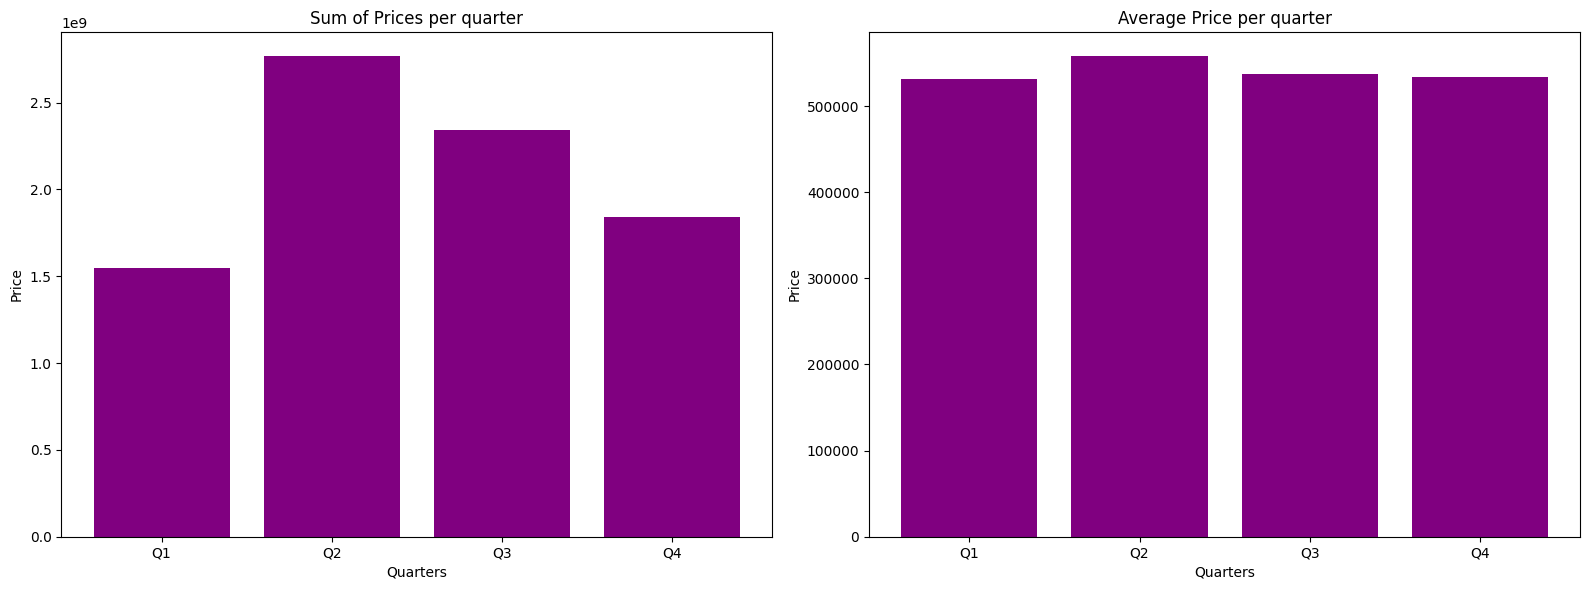

In [203]:
# Converting 'date' column to date-time format
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month.astype(str)

# Converting to quartes
def replace_quarters(x):
    """A bit complex but simple function to demarcate months into quarters"""
    x = int(x)
    if x <= 3:
        str_ = str(x).replace(str(x), "Q1")
    elif 4 <= x <= 6:
        str_ = str(x).replace(str(x), "Q2")
    elif 7 <= x <= 9:
        str_ = str(x).replace(str(x), "Q3")
    elif 10 <= x <= 12:
        str_ = str(x).replace(str(x), "Q4")

    return str_

# Replacing in the column
df["month"] = df['month'].map(replace_quarters)

# Visualizing
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

plot_sum = df.groupby("month")["price"].sum()
plot_mean = df.groupby("month")["price"].mean()

ax[0].bar(plot_sum.index, plot_sum.values, color='purple')
ax[1].bar(plot_mean.index, plot_mean.values, color='purple')

ax[0].set(ylabel='Price', xlabel='Quarters', title='Sum of Prices per quarter')
ax[1].set(ylabel='Price', xlabel='Quarters', title='Average Price per quarter')

plt.tight_layout()
plt.show()

* ##### There is no much difference between the quarters except that the average price in quarter 2 is slightly higher than the rest.

* ##### There are columns in the dataset that may not be useful in our evaluation and we thus drop them by first initializing the list called *dropped* and then dropping them from our dataset

In [204]:
# Initializing a list for columns to drop
def drop_cols(data, subset, axis):
    """A simple function to drop columns"""
    data.drop(subset, axis=axis, inplace=True)
    
dropped = ['id', 'date', 'view', 'lat', 'long', 'month']
    
drop_cols(df, dropped, 1)

* ##### In the cells below, the column 'grade' is split for its values and only the first section is singled out to be converted into numeric type and used as a scale for measuring the grade of the houses / properties 
* ##### Shifting has been done so that the grading parameters may start from 1.
* ##### From 1 to 11, where the lowest has ``1 as Poor``, with a midpoint having ``7 as average``, and the highest being ``11 as Mansion``

In [205]:
# Here we are checking the grading system used in the dataset
df['grade'].value_counts()

7 Average        6503
8 Good           4429
9 Better         1922
6 Low Average    1459
10 Very Good      832
11 Excellent      288
5 Fair            163
12 Luxury          66
4 Low              16
13 Mansion         11
3 Poor              1
Name: grade, dtype: int64

In [206]:
# Converting the 'grade' column to numeric dtype and shifting the scale by 2
df['grade'] = df['grade'].map(lambda x: x.split(' ')[0]).astype(int) - 2

In [207]:
# Transforming 'yr_renovated' column into a categorical variable with `renovated` and `not_renovated` 
def replace(x):
    """A simple function to categorize the column into renovated and not_renovated"""
    if x > 0:
        str_ = str(x).replace(str(x), "renovated")
    else:
        str_ = str(x).replace(str(x), "not renovated")
    return str_

# Renaming our coulumn and calling our function on the dataset
df['renovated'] = df.yr_renovated.map(replace)

# Viewing the changes
df.renovated.value_counts()

# Dropping the original column
df.drop('yr_renovated', axis=1, inplace=True)

* ##### Replacing the '?' in the column 'sqft_basement' with zero values since the entries in those columns showed similar areas for "sqft_living" and "sqft_above'

In [208]:
# Replacing the '?' character with "0.0"
df['sqft_basement'].replace({'?': "0.0"}, inplace=True)

# Converting the column 'sqft_basement' to an integer column
df['sqft_basement'] = df.sqft_basement.astype(float)

>> ### Checking for outliers in our price column

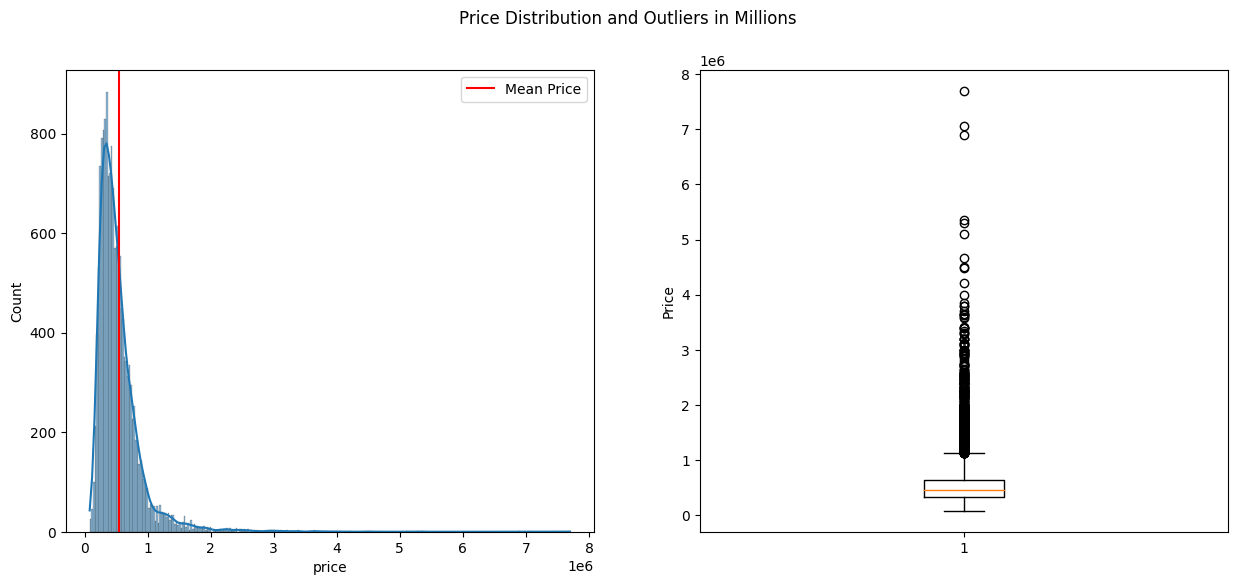

In [209]:
# Creating a figure space and visualizing
fig, ax = plt.subplots(figsize=(15,6), ncols=2)

# Histogram
sns.histplot(df.price, kde=True, ax=ax[0])
ax[0].axvline(df['price'].mean(), color='red', label="Mean Price")

# Boxplot
ax[1].boxplot(df['price'])
ax[1].set_ylabel("Price")
ax[0].legend()

# Title and showing
fig.suptitle("Price Distribution and Outliers in Millions")
plt.show()

* ##### From the above visualizations, we see that a majority of the price distributions lie between 0 and 1.2 million with those beyond this considered as outliers. On the other hand, we consider these prices to be important for our analysis except those above 5 million that we considered as genuine outliers which we will drop

In [210]:
# Checking the shape before the change
print(f'Before dropping outliers: {df.shape}')

# Dropping outliers
df = df.loc[df['price'] < 5_000_000]

# Confirming the changes done
print(f'After dropping outliers: {df.shape}')

Before dropping outliers: (15690, 16)
After dropping outliers: (15684, 16)


In [211]:
# Getting descriptive statistics on our dataset
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
count,1.568400e+04,15684.000000,15684.000000,15684.000000,1.568400e+04,15684.000000,15684.000000,15684.000000,15684.000000,15684.000000,15684.000000,15684.000000,15684.000000,15684.000000
mean,5.396884e+05,3.377200,2.121270,2084.560954,1.530694e+04,1.496685,3.411566,5.666220,1792.999044,285.441023,1971.194848,98077.501658,1991.250765,12920.620314
std,3.569768e+05,0.903297,0.762768,908.912907,4.198147e+04,0.539714,0.651190,1.168288,822.243155,439.771712,29.344129,53.369371,683.026015,28071.556152
min,8.200000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,1.000000,370.000000,0.000000,1900.000000,98001.000000,399.000000,659.000000
25%,3.213818e+05,3.000000,1.750000,1430.000000,5.046750e+03,1.000000,3.000000,5.000000,1200.000000,0.000000,1952.000000,98033.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.599500e+03,1.500000,3.000000,5.000000,1570.000000,0.000000,1975.000000,98065.000000,1850.000000,7620.000000
75%,6.446250e+05,4.000000,2.500000,2550.000000,1.070125e+04,2.000000,4.000000,6.000000,2220.000000,540.000000,1997.000000,98117.000000,2370.000000,10100.250000
max,4.670000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,11.000000,9410.000000,4820.000000,2015.000000,98199.000000,6210.000000,871200.000000


In [212]:
# Sowcasing the maximum, average and minimum market prices
print(f"""
      The average price in King County is {round(df.price.mean(), 2)},
      it has the hihgest price and lowest price being {round(df.price.max())} and {round(df.price.min())} respectively
      """)



      The average price in King County is 539688.37,
      it has the hihgest price and lowest price being 4670000 and 82000 respectively
      


## **Modelling**

* Checking our dataset for columns with high multicolinearity and dropping them as well due to their redundancy

In [213]:
def model_results(y, X):
    """A perfect use of a simple function to fit the models"""
    model = sm.OLS(y, sm.add_constant(X))
    fit = model.fit()
    return fit

In [214]:
# Checking for Multicollinearity in our predictors
corr_df = df.corr(numeric_only=True).abs().stack().reset_index().sort_values(0, ascending=False)
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# Dropping 'level_0' and 'level_1' 
corr_df.set_index(['pairs'], inplace=True)
corr_df.drop(columns=['level_0', 'level_1'], inplace=True)

# Renaming our column
corr_df.columns = ["corr_coef"]


In [215]:
# Veiwing the highly correlated predictor pairs
corr_df[(corr_df.corr_coef > 0.75) & (corr_df.corr_coef < 1)]

,corr_coef
pairs,
"(sqft_above, sqft_living)",0.874010
"(sqft_living, sqft_above)",0.874010
"(sqft_living, grade)",0.764519
"(grade, sqft_living)",0.764519
"(sqft_living, sqft_living15)",0.758122
"(sqft_living15, sqft_living)",0.758122
"(grade, sqft_above)",0.757643
"(sqft_above, grade)",0.757643
"(sqft_living, bathrooms)",0.751433


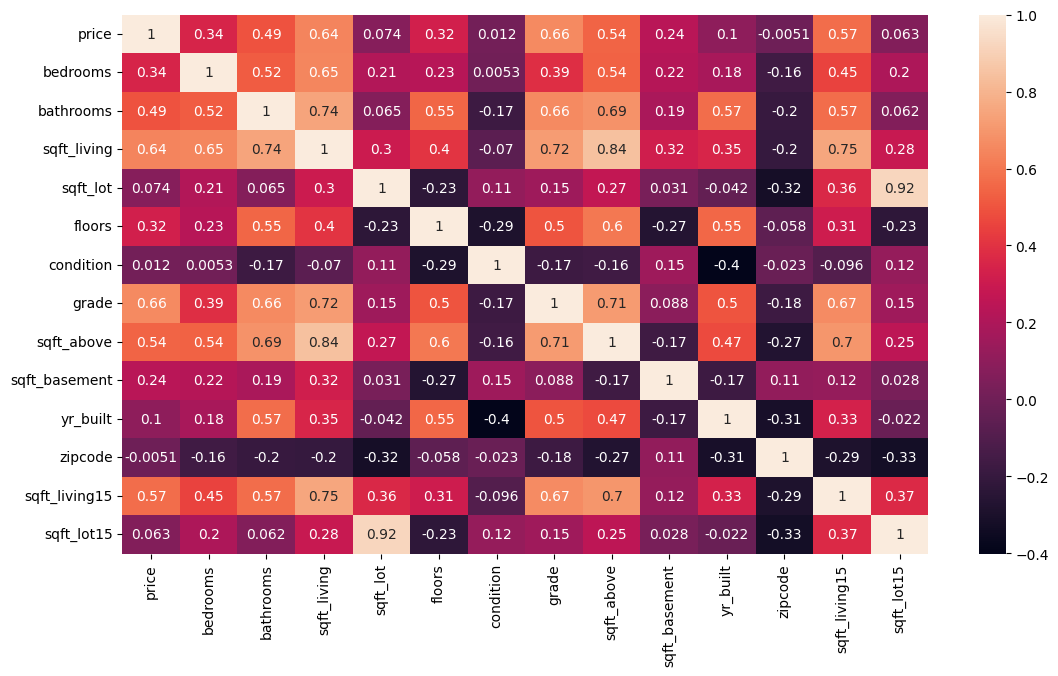

In [216]:
# Visualizing the correlation between predictors
plt.figure(figsize=(13,7))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True);

>>* ##### From the observations made above we see that there is a very high correlation between the predictor columns of 'sqft_above', 'sqft_living', 'sqft_living15, 'grade',and 'bathrooms'. Dropping some of these will eliminate multicollinearity features.
>>* ##### The columns to drop will be 'sqft_above', 'sqft_living15', 'grade',and 'bathrooms'

In [217]:
# Initializing a list of columns to drop
high_corr_pred = ['sqft_above', 'sqft_living15', 'grade', 'bathrooms']

# Dropping the columns permanently             
drop_cols(df, high_corr_pred, 1)

# Viewing the the remaining dataset
print(df.shape)
df.head()

(15684, 12)


,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_basement,yr_built,zipcode,sqft_lot15,renovated
1,538000.0,3,2570,7242,2.0,NO,3,400.0,1951,98125,7639,renovated
3,604000.0,4,1960,5000,1.0,NO,5,910.0,1965,98136,5000,not renovated
4,510000.0,3,1680,8080,1.0,NO,3,0.0,1987,98074,7503,not renovated
5,1230000.0,4,5420,101930,1.0,NO,3,1530.0,2001,98053,101930,not renovated
6,257500.0,3,1715,6819,2.0,NO,3,0.0,1995,98003,6819,not renovated


### Fitting our baseline model

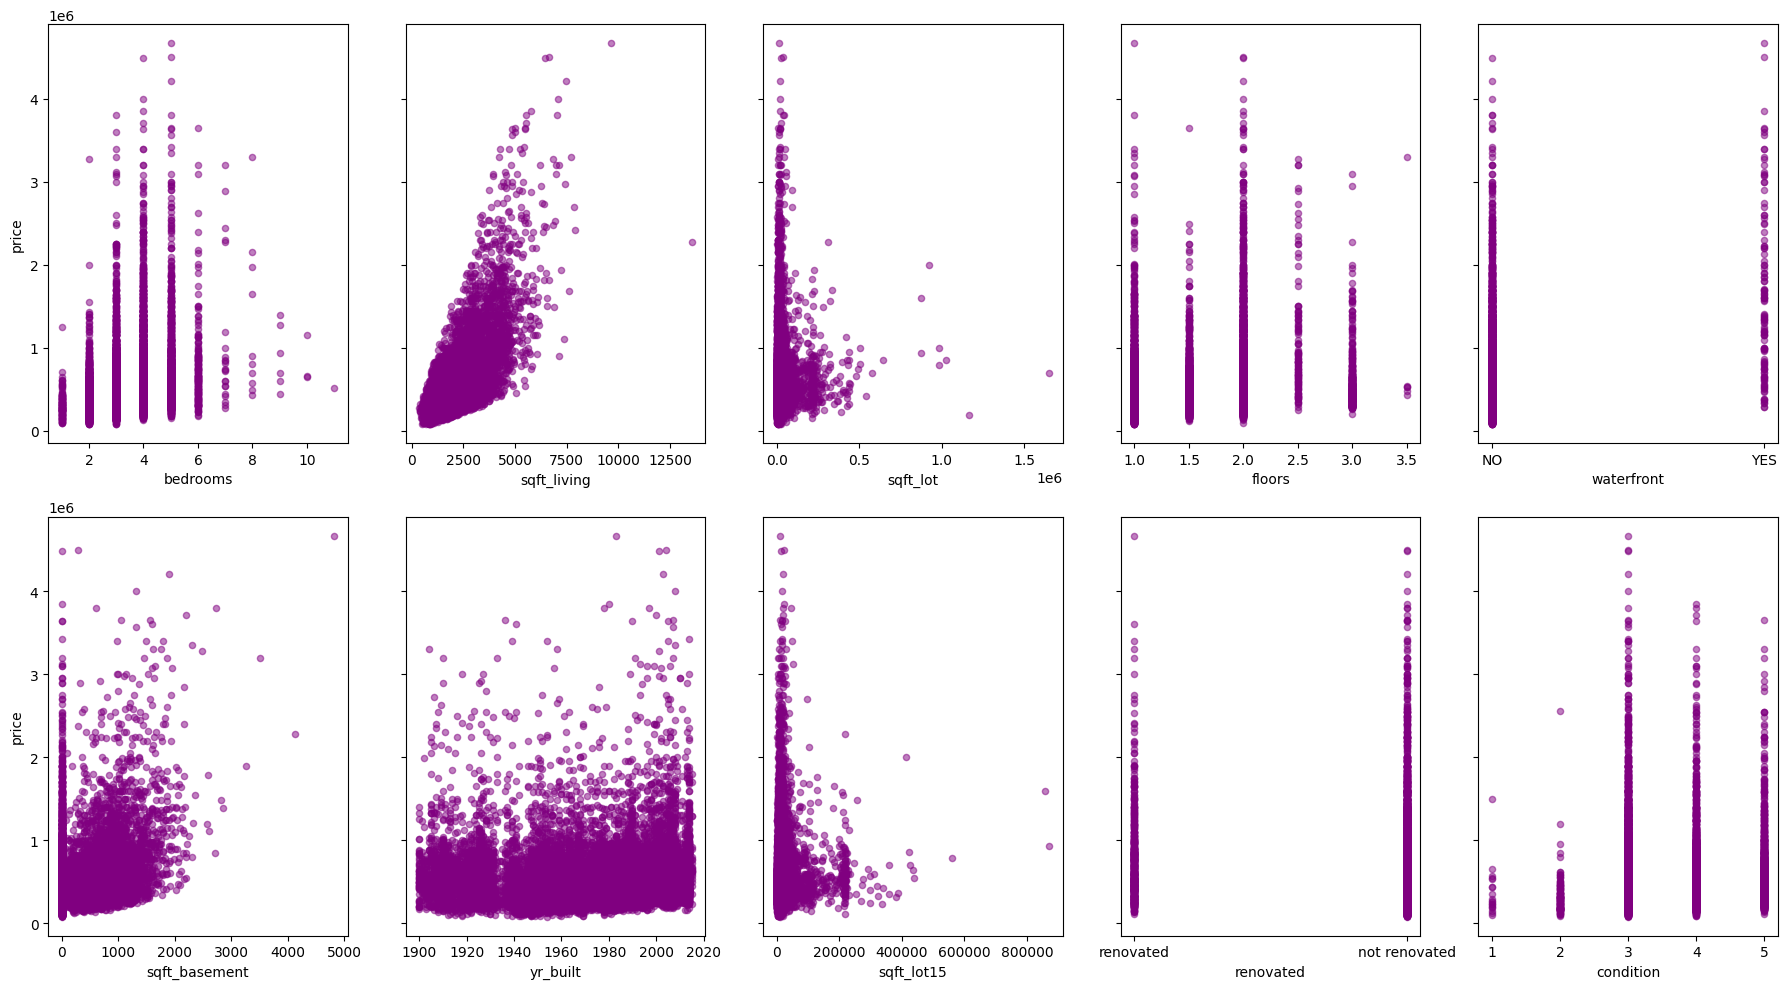

In [218]:
# Visualization of the predictor relationships with price
fig = plt.figure(figsize=(18,10))

axes = fig.subplots(nrows=2, ncols=5, sharey=True)

for xcol, ax in zip(['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',\
    'sqft_basement', 'yr_built', 'sqft_lot15', 'renovated', 'condition'], axes.flatten()):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.5, color='purple')
    
plt.tight_layout()
plt.show()

In [219]:
# Checking for the highly correlated
df.corr(numeric_only=True)['price']

price            1.000000
bedrooms         0.317642
sqft_living      0.700306
sqft_lot         0.084651
floors           0.264193
condition        0.035804
sqft_basement    0.309243
yr_built         0.051680
zipcode         -0.046585
sqft_lot15       0.079721
Name: price, dtype: float64

In [220]:
# Determining the variables
y = df['price']
X_baseline = df[['sqft_living']]

In [221]:
# Fitting the model
baseline_results = model_results(y, X_baseline)

# Our summary
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                 1.509e+04
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:45:26   Log-Likelihood:            -2.1749e+05
No. Observations:               15684   AIC:                         4.350e+05
Df Residuals:                   15682   BIC:                         4.350e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.366e+04   5091.274     -6.612      

>>* ##### The model is generally statistically sigmificant at a significance level of $\alpha = 0.05$ with a $p$_value of 0.0, and explains about 49% of the variance in price.
>>* ##### The constant and coefficient are statistically significant.
>>* ##### For a unit increase in square-foot living area, we see an associated increase in 275 dollars in selling price of the houses.


In [222]:
# Fitting a multiple regression 
X_multiple = df.copy().drop(['price', 'zipcode'], axis=1)
X_multiple = pd.get_dummies(X_multiple, columns=['waterfront', 'renovated'], drop_first=True)
X_multiple

,bedrooms,sqft_living,sqft_lot,floors,condition,sqft_basement,yr_built,sqft_lot15,waterfront_YES,renovated_renovated
1,3,2570,7242,2.0,3,400.0,1951,7639,0,1
3,4,1960,5000,1.0,5,910.0,1965,5000,0,0
4,3,1680,8080,1.0,3,0.0,1987,7503,0,0
5,4,5420,101930,1.0,3,1530.0,2001,101930,0,0
6,3,1715,6819,2.0,3,0.0,1995,6819,0,0
...,...,...,...,...,...,...,...,...,...,...
21591,3,1310,1294,2.0,3,130.0,2008,1265,0,0
21592,3,1530,1131,3.0,3,0.0,2009,1509,0,0
21593,4,2310,5813,2.0,3,0.0,2014,7200,0,0
21594,2,1020,1350,2.0,3,0.0,2009,2007,0,0


In [223]:
# Fittng our multiple regression model
multiple_results = model_results(y, X_multiple)

print(multiple_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2195.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:45:27   Log-Likelihood:            -2.1591e+05
No. Observations:               15684   AIC:                         4.318e+05
Df Residuals:                   15673   BIC:                         4.319e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.863e+06    

>>* ##### The model overall is statistically significant at standard alpha of 0.05 being 0.0, and it explains 58% percent of the variance in sale price.
>>* ##### The model coefficients are statistically significant except for "sqft_lot".
>>* ##### In comparison to our baseline model, our multiple model is an improvement with explained variance in price from 49% to 58%
>>* ##### The constant here explains that all factors held constant, and a house with no waterfront and not renovated, we would have a sale price of 4,844,000 dollars

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


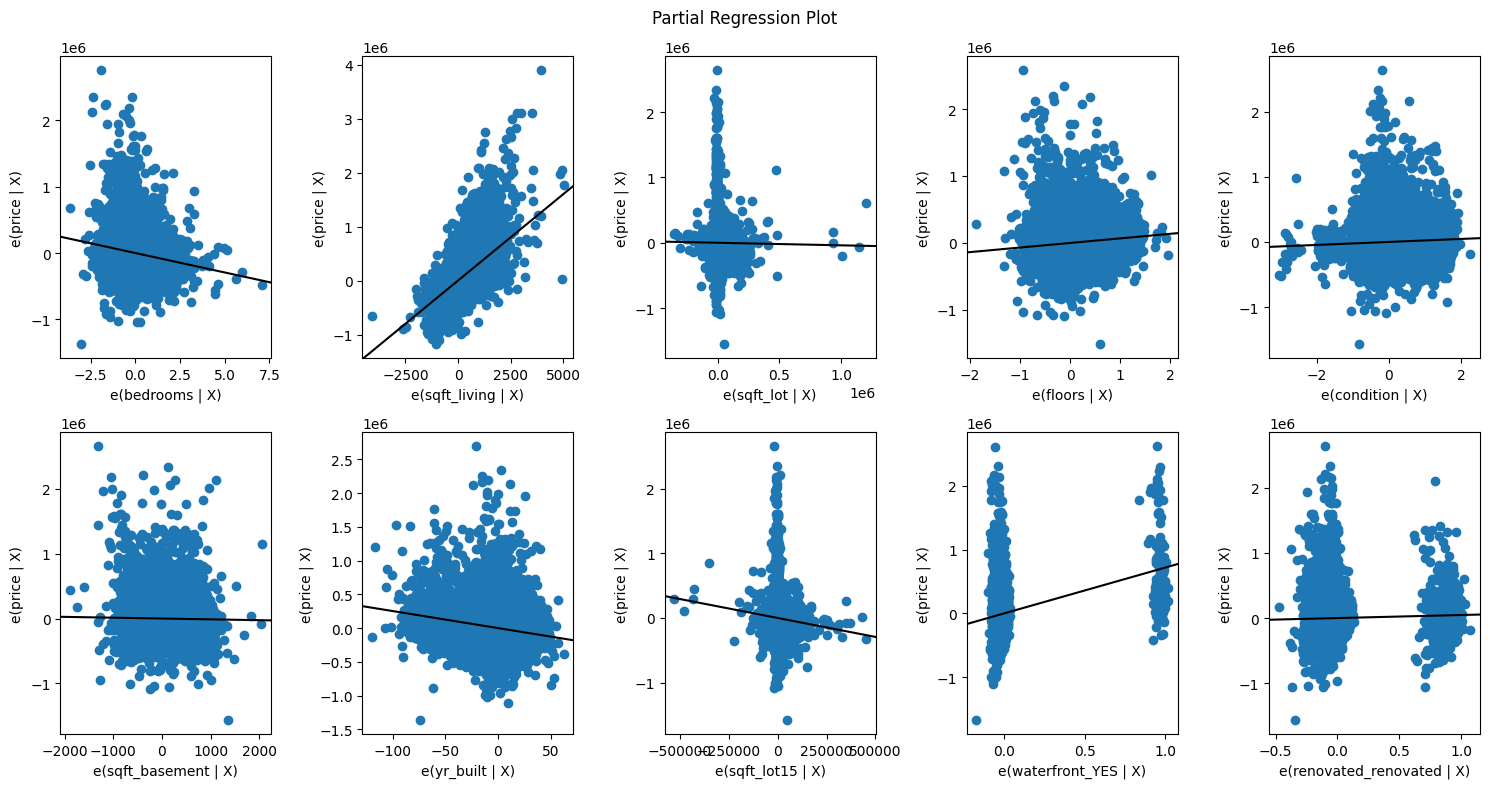

In [224]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    multiple_results,
    exog_idx=list(X_multiple.columns.values),
    grid=(2,5),
    fig=fig)

plt.tight_layout()
plt.show()